In [1]:
from IPython.core.display import display,HTML
display(HTML('<style>.prompt{width: 0px; min-width: 0px; visibility: collapse}</style>'))

%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi=False

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact, Dropdown, IntSlider
from tqdm import tqdm_notebook


train_acl = pd.read_csv('/home/medmantra/Downloads/KneeMR_AI/DB/MRNet-v1.0/MRNet-v1.0/train-acl.csv', header=None,
                       names=['Case', 'Abnormal'], 
                       dtype={'Case': str, 'Abnormal': np.int64})

train_acl.head()

,Case,Abnormal
0,0000,0
1,0001,1
2,0002,0
3,0003,0
4,0004,0


In [2]:
print(train_acl.shape)
# (1130, 2)


(1130, 2)


In [3]:
train_acl.Abnormal.value_counts(normalize=True)

# 0    0.815929
# 1    0.184071
# Name: Abnormal, dtype: float64

0    0.815929
1    0.184071
Name: Abnormal, dtype: float64

In [4]:
case = '0000'

mri_coronal = np.load('/home/medmantra/Downloads/KneeMR_AI/DB/MRNet-v1.0/MRNet-v1.0/train/coronal/0000.npy')
mri_axial = np.load('/home/medmantra/Downloads/KneeMR_AI/DB/MRNet-v1.0/MRNet-v1.0/train/axial/0000.npy')
mri_sagittal = np.load('/home/medmantra/Downloads/KneeMR_AI/DB/MRNet-v1.0/MRNet-v1.0/train/sagittal/0000.npy')

print(f'MRI scan on coronal plane: {mri_coronal.shape}')
print(f'MRI scan on axial plane: {mri_axial.shape}')
print(f'MRI scan on sagittal plane: {mri_sagittal.shape}')

MRI scan on coronal plane: (36, 256, 256)
MRI scan on axial plane: (44, 256, 256)
MRI scan on sagittal plane: (36, 256, 256)


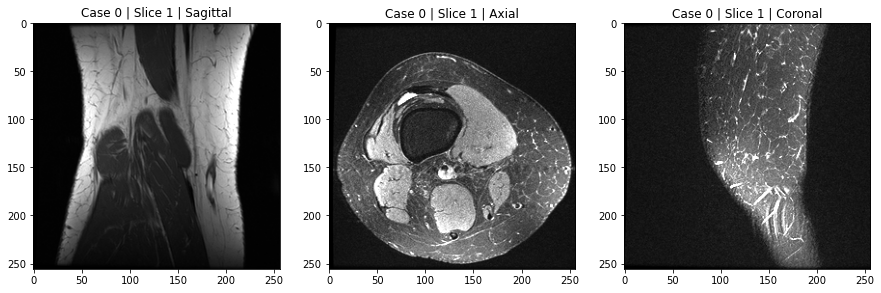

In [5]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.imshow(mri_coronal[0, :, :], 'gray');
ax1.set_title('Case 0 | Slice 1 | Sagittal');

ax2.imshow(mri_axial[0, :, :], 'gray');
ax2.set_title('Case 0 | Slice 1 | Axial');

ax3.imshow(mri_sagittal[0, :, :], 'gray');
ax3.set_title('Case 0 | Slice 1 | Coronal');

In [6]:
train_path = '/home/medmantra/Downloads/KneeMR_AI/DB/MRNet-v1.0/MRNet-v1.0/train/'

def load_one_stack(case, data_path=train_path, plane='coronal'):
    fpath = '{}/{}/{}.npy'.format(data_path, plane, case)
    return np.load(fpath)

def load_stacks(case, data_path=train_path):
    x = {}
    planes = ['coronal', 'sagittal', 'axial']
    for i, plane in enumerate(planes):
        x[plane] = load_one_stack(case, plane=plane)
    return x

def load_cases(train=True, n=None):
    assert (type(n) == int) and (n < 1250)
    if train:
        case_list = pd.read_csv('/home/medmantra/Downloads/KneeMR_AI/DB/MRNet-v1.0/MRNet-v1.0/train-acl.csv', names=['case', 'label'], header=None,
                               dtype={'case': str, 'label': np.int64})['case'].tolist()        
    else:
        case_list = pd.read_csv('/home/medmantra/Downloads/KneeMR_AI/DB/MRNet-v1.0/MRNet-v1.0/valid-acl.csv', names=['case', 'label'], header=None,
                               dtype={'case': str, 'label': np.int64})['case'].tolist()        
    cases = {}
    
    if n is not None:
        case_list = case_list[:n]
        
    for case in tqdm_notebook(case_list, leave=False):
        x = load_stacks(case)
        cases[case] = x
    return cases

cases = load_cases(n=100)

ipykernel_launcher:27: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [7]:
print(cases['0000'].keys())

#dict_keys(['coronal', 'sagittal', 'axial'])

dict_keys(['coronal', 'sagittal', 'axial'])


In [8]:
print(cases['0000']['axial'].shape)
print(cases['0000']['coronal'].shape)
print(cases['0000']['sagittal'].shape)

# (44, 256, 256)
# (36, 256, 256)
# (36, 256, 256)

(44, 256, 256)
(36, 256, 256)
(36, 256, 256)


In [9]:
class KneePlot():
    def __init__(self, cases, figsize=(15, 5)):
        self.cases = cases
        
        self.planes = {case: ['coronal', 'sagittal', 'axial'] for case in self.cases}
    
        self.slice_nums = {}
        for case in self.cases:
            self.slice_nums[case] = {}
            for plane in ['coronal', 'sagittal', 'axial']:
                self.slice_nums[case][plane] = self.cases[case][plane].shape[0]

        self.figsize = figsize
        
    def _plot_slices(self, case, im_slice_coronal, im_slice_sagittal, im_slice_axial):
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=self.figsize)
        
        ax1.imshow(self.cases[case]['coronal'][im_slice_coronal, :, :], 'gray')
        ax1.set_title(f'MRI slice {im_slice_coronal} on coronal plane')
        
        ax2.imshow(self.cases[case]['sagittal'][im_slice_sagittal, :, :], 'gray')
        ax2.set_title(f'MRI slice {im_slice_sagittal} on sagittal plane')
        
        ax3.imshow(self.cases[case]['axial'][im_slice_axial, :, :], 'gray')
        ax3.set_title(f'MRI slice {im_slice_axial} on axial plane')
        
        plt.show()
    
    def draw(self):
        case_widget = Dropdown(options=list(self.cases.keys()),
                               description='Case'
                              
                              )
        case_init = list(self.cases.keys())[0]


        slice_init_coronal = self.slice_nums[case_init]['coronal'] - 1        
        slices_widget_coronal = IntSlider(min=0, 
                                          max=slice_init_coronal, 
                                          value=slice_init_coronal // 2, 
                                          description='Coronal')
        
        slice_init_sagittal = self.slice_nums[case_init]['sagittal'] - 1        
        slices_widget_sagittal = IntSlider(min=0,
                                           max=slice_init_sagittal,
                                           value=slice_init_sagittal // 2,
                                           description='Sagittal'
                                          )
        
        slice_init_axial = self.slice_nums[case_init]['axial'] - 1        
        slices_widget_axial = IntSlider(min=0,
                                        max=slice_init_axial,
                                        value=slice_init_axial // 2,
                                        description='Axial'
                                       )
        
        def update_slices_widget(*args):
            slices_widget_coronal.max = self.slice_nums[case_widget.value]['coronal'] - 1
            slices_widget_coronal.value = slices_widget_coronal.max // 2
            
            slices_widget_sagittal.max = self.slice_nums[case_widget.value]['sagittal'] - 1
            slices_widget_sagittal.value = slices_widget_sagittal.max // 2
            
            slices_widget_axial.max = self.slice_nums[case_widget.value]['axial'] - 1
            slices_widget_axial.value = slices_widget_axial.max // 2
    
        
        case_widget.observe(update_slices_widget, 'value')
        interact(self._plot_slices,
                 case=case_widget, 
                 im_slice_coronal=slices_widget_coronal, 
                 im_slice_sagittal=slices_widget_sagittal, 
                 im_slice_axial=slices_widget_axial
                )
    
    def resize(self, figsize): 
        self.figsize = figsize

In [10]:
plot = KneePlot(cases)
plot.draw()

interactive(children=(Dropdown(description='Case', options=('0000', '0001', '0002', '0003', '0004', '0005', '0…